# Optimize

**Table of contents**<a id='toc0_'></a>    
- 1. [Algorithm 1: Simple loops](#toc1_)    
- 2. [Algorithm 2: Use monotonicity](#toc2_)    
- 3. [Algorithm 3: Call a solver](#toc3_)    
- 4. [Indifference curves](#toc4_)    
- 5. [Advanced: A classy solution](#toc5_)    
  - 5.1. [Jeppe](#toc5_1_)    
  - 5.2. [Mette](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Most economic models contain optimizing agents solving a constrained optimization problem. 

Solving a numerical optimization problems can be done using algorithms. 

And also using the module **optimize** from **[scipy](https://scipy.org/)**.

- **scipy-optimize**: [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html)

## 1. <a id='toc1_'></a>[Algorithm 1: Simple loops](#toc0_)

CHR: We loop through the possible solutions and then we pick the solution that yields the maximum value

Consider an economic optimization problem:

$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1},x_{2}}u(x_{1},x_{2})\\
 & \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq I,\,\,\,p_{1},p_{2},I>0\\
x_{1},x_{2} & \geq 0
\end{aligned}
$$

**Idea:** Loop through a grid of $N_1 \times N_2$ hypothetical solutions.  
This is the same as solving:
$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1}\in X_1,x_{2} \in X_2} x_1^{\alpha}x_2^{1-\alpha}\\
 & \text{s.t.}\\
 X_1 & = \left\{0,\frac{1}{N_1-1}\frac{I}{p_1},\frac{2}{N_1-1}\frac{I}{p_1},\dots,\frac{I}{p_1}\right\} \\
 X_2 & = \left\{0,\frac{1}{N_2-1}\frac{I}{p_2},\frac{2}{N_2-1}\frac{ I}{p_2},\dots,\frac{ I}{p_2}\right\} \\
p_{1}x_{1}+p_{2}x_{2} & \leq I\\
\end{aligned}
$$
Where we used the budget constraint to create the **grids** $X_1$ and $X_2$

CHR: Note we still have to keep the budget constraint, because else we could get from the grid that the individual spends all her money on x1 and she also spends all her money x2, so she spends all her money twice.

In the module **grid_solve.py**, we have functions doing that.  
We must **import** those functions before using them in the notebook.   
First 2 lines ensures that we automatically load changes to any file while editing (**always add this**).  
Next we load all functions from `grid_solve` (`*` means get all in general)

In [5]:
# Ensures automatic reloading of module
# CHR: When you change functions in your py-file you don't have to reload everything if you have the following two lines of code
%load_ext autoreload 
%autoreload 2
# Import all functions from module "grid_solve" 
from grid_solve import * 
#CHR: * means load all functions. You could have also written the name of a given function
#CHR: can also open the module by marking grid_solve and then pressing fn+f12

CHR: When you open in a py-file you always have to import all the packages that you would like to use in that py-file.

In [4]:
# Numpy and plotting packages
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt # baseline module
from mpl_toolkits.mplot3d import Axes3D # for 3d figures

from matplotlib import cm # for colormaps
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

#CHR: The code above was covered in the plot notebook

In [2]:
def u_func(x1,x2,alpha=0.50):
    return x1**alpha * x2**(1-alpha)

Go to `grid_solve` and inspect the function `find_best_choice`. It implements the algo above.   

In [3]:
# Call function and see output
sol = find_best_choice(alpha=0.25,I=10,p1=1,p2=2,N1=500,N2=400,do_print=True)
# See printed result below 

x1 = 2.5050
x2 = 3.7469
u  = 3.3881
I-p1*x1-p2*x2 = 0.00125564
x1*p1/I = 0.2505


**Plot the solution:**

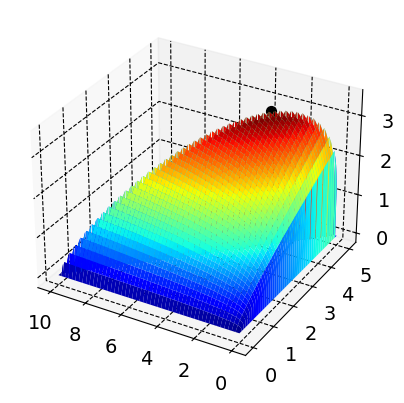

In [6]:
#%matplotlib widget
# a. unpack solution
x1_best,x2_best,u_best,x1_values,x2_values,u_values = sol
#CHR: we saved the solution as sol and here we unpack it to seperate variables

# b. setup figure
fig = plt.figure(dpi=100,num='')
ax = fig.add_subplot(1,1,1,projection='3d')

# c. plot 3d surface of utility values for different choices
ax.plot_surface(x1_values,x2_values,u_values,cmap=cm.jet)

ax.invert_xaxis()

# d. plot optimal choice
ax.scatter(x1_best,x2_best,u_best,s=50,color='black');

#%matplotlib inline

**Question:** If you comment out the ax.invert_xaxis(), you'll see that u=0 for many of the combinations of $x_1$ and $x_2$, why is that? 

#CHR: this comes back to out loop where if we used more than our income then we set utility to 0

**Task**: Can you find a better solution with higher utility and lower left-over income, $I-p_1 x_1-p_2 x_2$?

In [7]:
# write your code here
sol = find_best_choice(alpha=0.25,I=10,p1=1,p2=2,N1=1000,N2=1000,do_print=True)
#CHR: I just added more observations

x1 = 2.5025
x2 = 3.7487
u  = 3.3885
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.2503


## 2. <a id='toc2_'></a>[Algorithm 2: Use monotonicity](#toc0_)

#CHR: Just adding more observations is not an ideal solution (takes time, etc.). Instead we use monotonicity, where we don't check all the points where we spend less than our income.

**Better idea:** Loop through a grid of $N$ possible solutions for $x_1$ and assume the remainder is spent on $x_2$.   
This is the same as solving:

$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1}\in X_1} x_1^{\alpha}x_2^{1-\alpha}\\
 \text{s.t.}\\
 X_1 & = \left\{0,\frac{1}{N-1}\frac{I}{p_1},\frac{2}{N-1}\frac{I}{p_1},\dots,\frac{I}{p_1}\right\} \\
x_{2} & = \frac{I-p_{1}x_{1}}{p_2}\\
\end{aligned}
$$

Function doing just this is `find_best_choice_monotone` in `grid_solve.py`

In [8]:
# a. Calling the algo using monotonicity
sol_monotone = find_best_choice_monotone(alpha=0.25,I=10,p1=1,p2=2,N=500)
#note now we only use 500 data points, before we were using a grid of 500*500 observations

# b. unpack solution
x1_best,x2_best,u_best,x1_values,x2_values,u_values = sol_monotone

x1 = 2.5050
x2 = 3.7475
u  = 3.3885
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.2505


Plot the solution:

Text(0, 0.5, '$x_2$')

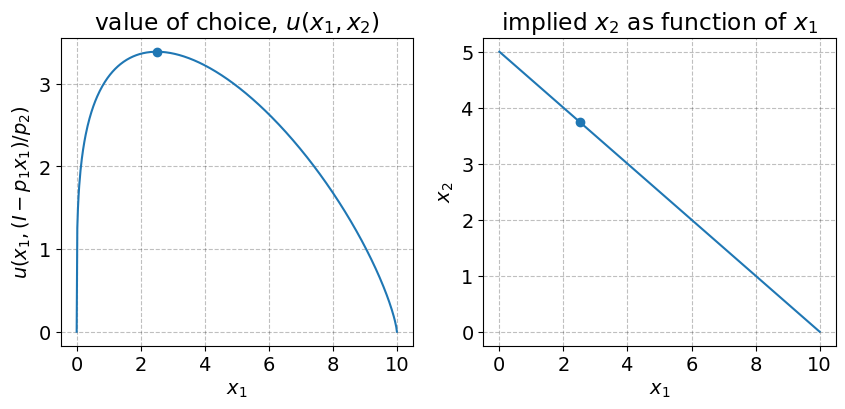

In [13]:
#CHR: Note: since we did not define a grid, we cannot use a 3d plot, so we have to do two seperate plots
# one for x1,u and one for x2, u

# a. create the figure
fig = plt.figure(figsize=(10,4))# figsize is in inches...

# b. left plot
ax_left = fig.add_subplot(1,2,1) #CHR: because we want two plots next to eachother then we set two columns, this is the first figure...

ax_left.plot(x1_values,u_values)
ax_left.scatter(x1_best,u_best) # Add the solution as a dot

ax_left.set_title('value of choice, $u(x_1,x_2)$')
ax_left.set_xlabel('$x_1$')
ax_left.set_ylabel('$u(x_1,(I-p_1 x_1)/p_2)$')


# c. right plot
ax_right = fig.add_subplot(1,2,2) #CHR: ...and this is the second figure

ax_right.plot(x1_values,x2_values)
ax_right.scatter(x1_best,x2_best)

ax_right.set_title('implied $x_2$ as function of $x_1$')
ax_right.set_xlabel('$x_1$')
ax_right.set_ylabel('$x_2$')

plt.close(fig) # (Suppress print to fit slides) 
#CHR: This is often used to clear the plot and start a new one without generating multiple overlapping plots

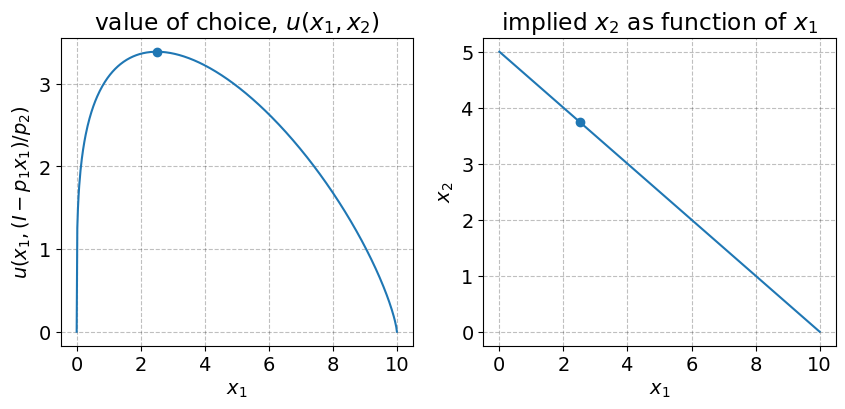

In [14]:
#Show figures of solution
fig

## 3. <a id='toc3_'></a>[Algorithm 3: Call a solver](#toc0_)


- **scipy-optimize**: [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html)

In [3]:
# Now we use the library scipy to do the heavy lifting
from scipy import optimize

Choose paramters for economic model:

In [2]:
alpha = 0.25 # preference parameter
I = 10 # income
p1 = 1 # price 1
p2 = 2 # price 2

**Case 1**: Scalar solver using monotonicity.  
Note that we are calling a **minimizer**. Take **negative** of utility.  
Recall that we if we spend everything on good one, we get $x_1 = I/p_1$. 

#CHR: A scalar solver takes one argument and outputs one argument. This is sort of the most simple solver.

#CHR: In numerical computering you never maximize stuff, you always minimize - so we take the negative of whatever we are trying to maximize

In [21]:
# a. objective function (to minimize)
def value_of_choice(x1,alpha,I,p1,p2): # CHR: python will only solve for x1, we give python the rest of the arguments
    x2 = (I-p1*x1)/p2 #CHR: we still use monotonicity implicitly
    return -u_func(x1,x2,alpha)

# b. call solver
sol_case1 = optimize.minimize_scalar( #CHR: we call the solution sol_case1
    value_of_choice,
    method='bounded',
    bounds=(0,I/p1),
    args=(alpha,I,p1,p2)) # Notice the use of a tuple here
#CHR: minimize scalar wants the function, that we want to minimize
#then it wants a method. we use bounded because this allows to use bounds
#bounds = (min, max) specifies the bounds for x1
#args specifies the list of arguments we have other than the variable which we use to minimize
#the solver will then itself find out how to minimize the function

# c. unpack solution
x1 = sol_case1.x #CHR: x is an attribute that calls the solution argument, the x that maximizes the utility
x2 = (I-p1*x1)/p2
u = u_func(x1,x2,alpha)
print_solution(x1,x2,u,I,p1,p2)

x1 = 2.5000
x2 = 3.7500
u  = 3.3885
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.2500


In [22]:
#CHR: We can also call the attribute fun
sol_case1.fun

-3.3885075135369176

CHR: This shows us the function value of the solution, but note that this is negative, because we set minus in front of the utility function

**Case 2**: **Multi-dimensional constrained** solver, the *SLSQP*.

#CHR: if x2 is not implied by x1 then we use a multi-dimensional constrained solver

In [6]:
# a. objective function (to minimize)
def value_of_choice(x,alpha,I,p1,p2):
    # note: x is a array, but u_func takes scalars.
    return -u_func(x[0],x[1],alpha) #so we specify x1 as x[0] and x2 as x[1]

# b. constraints (violated if negative) and bounds. x is an array.
constraints = ({'type': 'ineq', 'fun': lambda x:  I-p1*x[0]-p2*x[1]})
bounds = ((0,I/p1),(0,I/p2))
#CHR: constraints is just a dictionary:
#1) The type of constraint we want is an inequality constraint. We could have also written eq, then it would have been an equality constraint
#2) then you define the function, which defines your constraint. it has to take the x as also specified up in the definition of the function
#CHR: The constraints basically specify that you want the income function to always be positive or 0
#CHR: bounds specify a tuple with upper and lower limits of x1 and x2

# c. call solver, use SLSQP
initial_guess = [I/p1/2,I/p2/2]
#CHR: We give an initial guess. It can be almost anything, it just has to be within the bounds.

sol_case2 = optimize.minimize(
    value_of_choice, initial_guess, args=(alpha,I,p1,p2),
    method='SLSQP', bounds=bounds, constraints=constraints)
#CHR: note before we had minimize_scalar, but now we have just minimize. this is because we now have a vector function x.
#1) objective function
#2) initial guess
#3) the arguments
#4) method is slsqp - check scipy documentation. can take bounds and constraints. Nelder-mead can do the same, but it is a sort of more "brute force" method.
#5) specify bounds
#6) specify constraints

# d. unpack solution
x1 = sol_case2.x[0] #CHR: Note how we unpack x since it is now a vector
x2 = sol_case2.x[1]
u = u_func(x1,x2,alpha)
print_solution(x1,x2,u,I,p1,p2)

x1 = 2.4994
x2 = 3.7503
u  = 3.3885
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.2499


**Case 3**: Multi-dimensional unconstrained solver with constrains implemented via penalties.

#CHR: This way does not use constraints when you're calling the solver, but it sort of implements the constraints via penalties. He says it can sometimes be useful but recommends to use case 2 if possible

In [8]:
# a. objective function (to minimize)
def value_of_choice(x,alpha,I,p1,p2):
    
    # i. unpack
    x1 = x[0]
    x2 = x[1]
    
    # ii. penalty
    penalty = 0
    E = p1*x1+p2*x2 # total expenses
    if E > I: # expenses > income -> not allowed
        fac = I/E # fac < 1 if too high expenses
        penalty += 1000*(E-I) # calculate penalty   #CHR: note it is scaled with how much your expenses are larger than your income     
        x1 *= fac # force E = I #CHR: You scale your consumption of each good to make sure the utility you put out is only the one implied by the utility function
        x2 *= fac # force E = I #CHR: He says it would probably work without it if the penalty is high enough, but this ensures that it will work - we cannot get crazy values of x1 and x2 that would give us a high utility even though we have the penalty
    #CHR: The idea is that when we don't uphold the budget constraint, then we give add such a large number, that it cannot be a solution to the minimize problem
    
    return -u_func(x1,x2,alpha) + penalty

In [9]:
# b. call solver
initial_guess = [I/p1/2,I/p2/2]
sol_case3 = optimize.minimize(
    value_of_choice,initial_guess,method='Nelder-Mead',
    args=(alpha,I,p1,p2))
#CHR: Now we use method Nelder-Mead, this doesn't take constraints

# c. unpack solution
x1 = sol_case3.x[0]
x2 = sol_case3.x[1]
u = u_func(x1,x2,alpha)
print_solution(x1,x2,u,I,p1,p2)

x1 = 2.5000
x2 = 3.7500
u  = 3.3885
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.2500


## 4. <a id='toc4_'></a>[Indifference curves](#toc0_)

Remember that the indifference curve through the point $(y_1,y_2)$ is given by the set of $x_1,x_2$ points

$$
\big\{(x_1,x_2) \in \mathbb{R}^2_+ \,|\, u(x_1,x_2) = u(y_1,y_2)\big\}
$$

To find the indifference curve: 
* fix a grid for $x_2$
* then find the corresponding $x_1$ which solves $u(x_1,x_2) = u(y_1,y_2)$ for each value of $x_2$.

In [10]:
def objective(x1,x2,alpha,u):
    return u_func(x1,x2,alpha) - u 
    # = 0 then on indifference curve with utility = u

In [11]:
def find_indifference_curve(y1,y2,alpha,N,x2_max):
    
    # a. utility in (y1,y2)
    u_y = u_func(y1,y2,alpha) #CHR: We calculate the original utility
    
    # b. allocate numpy arrays
    x1_vec = np.empty(N) #CHR: we create an empty x1 vector
    x2_vec = np.linspace(1e-8,x2_max,N) 
    #CHR: X2_vec creates a grid from a very low number to a very high number. We can't use exactly 0 because we know from our utility function
    #that if x2 is exactly 0 then utility will be exactly zero and then there is no x1 that can set it to the original utility value
    
    # c. loop through x2
    for i,x2 in enumerate(x2_vec):

        x1_guess = 0 # initial guess
        sol = optimize.root(objective, x1_guess, args=(x2,alpha,u_y)) 
        # optimize.root -> solve objective = 0 starting from x1 = x1_guess
        #CHR: this is why we wrote the utility function as utility of x1 and x2 minus original utility, because we want that to be 0 at the indifference point
        #CHR and that's finding the root.
        
        x1_vec[i] = sol.x[0]
    
    return x1_vec,x2_vec

Find and plot an inddifference curve:

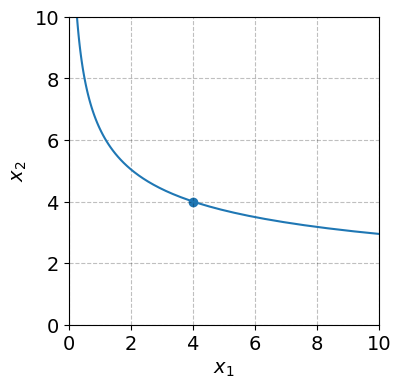

In [12]:
# a. find indifference curve through (4,4) for x2 in [0,10]
x2_max = 10
y1 = 4
y2 = 4
x1_vec,x2_vec = find_indifference_curve(y1,y2,alpha=0.25,N=100,x2_max=x2_max) 

# b. plot inddifference curve
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(x1_vec,x2_vec)
ax.scatter(y1,y2)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim([0,x2_max])
ax.set_ylim([0,x2_max]);


**Task:** Find the indifference curve through $x_1 = 15$ and $x_2 = 3$ with $\alpha = 0.5$.

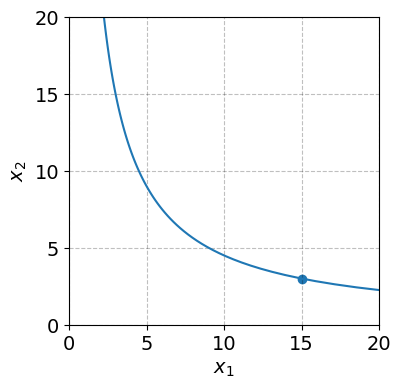

In [13]:
# write your code here
# a. find indifference curve through (4,4) for x2 in [0,10]
x2_max = 20
y1 = 15
y2 = 3
x1_vec,x2_vec = find_indifference_curve(y1,y2,alpha=0.5,N=100,x2_max=x2_max) 

# b. plot inddifference curve
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(x1_vec,x2_vec)
ax.scatter(y1,y2)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim([0,x2_max])
ax.set_ylim([0,x2_max]);


In [ ]:
# Answer
x2_max = 20 
y1 = 15
y2 = 3
x1_vec,x2_vec = find_indifference_curve(y1,y2,alpha=0.25,N=100,x2_max=x2_max) 



fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(x1_vec,x2_vec)
ax.scatter(y1,y2)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim([0,x2_max])
ax.set_ylim([0,x2_max]);

## 5. <a id='toc5_'></a>[Advanced: A classy solution](#toc0_)

> **Note:** This section is advanced due to the use of a module with a class. It is, however, a good example of how to structure code for solving and illustrating a model.

**Load module** (consumer_module.py in the same folder as this notebook).

In [ ]:
from consumer_module import consumer

### 5.1. <a id='toc5_1_'></a>[Jeppe](#toc0_)

Give birth to a consumer called **jeppe**:

In [ ]:
jeppe = consumer() # create an instance of the consumer class called jeppe
print(jeppe)

Solve **jeppe**'s problem.

In [ ]:
jeppe.solve()
print(jeppe)

### 5.2. <a id='toc5_2_'></a>[Mette](#toc0_)

Create a new consumer, called Mette, and solve her problem.

In [ ]:
mette = consumer(alpha=0.25)
mette.solve()
mette.find_indifference_curves()
print(mette)

Make an illustration of Mette's problem and it's solution:

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

mette.plot_indifference_curves(ax)
mette.plot_budgetset(ax)
mette.plot_solution(ax)
mette.plot_details(ax)

In [ ]:
mette.plot_everything()

**Advanced note:** Looking at the code behind the consumer class, you'll notice the 'self' argument a lot. This argument links the functions in the class definition, which holds all the instructions for behavior, and the specific object. And exactly because 'self' is the first argument in class functions, one can actually call the general class and provide it with the object one wants to evaluate a function on. 

In [ ]:
# Example: 
christian = consumer()

# Calling the consumer class function and providing the object christian :
consumer.solve(christian)
print('call to consumer class: \n',christian)

# is the same as the call to the christian object directly
christian.solve()
print('call to the object christian directly: \n',christian)